In [ ]:
from utils.load import load_data, load_submission
from utils.feature import (
    add_hours,
    add_hours_trig_cyclic,
    apply_feature_engineering,
    get_dummies,
    fill_na_zero,
    drop_non_input_cols,
    normalize,
    standardize
)
from utils.model import ModelEvalWrapper

In [ ]:
train_df, predict_df = load_data('../data')

In [ ]:
_train_df, _predict_df = apply_feature_engineering(
    train_df,
    predict_df,
    funcs=[
        add_hours,
        fill_na_zero("all"),
        normalize(["txpower_cell0", "txpower_cell1", "txpower_cell2", "txpower_cell3"]),
        normalize(
            [
                "bandwidth_cell0",
                "antennas_cell0",
                "bandwidth_cell1",
                "antennas_cell1",
                "bandwidth_cell2",
                "antennas_cell2",
                "bandwidth_cell3",
                "antennas_cell3",
            ]
        ),
        get_dummies(
            [
                "hour",
                "rutype",
                "mode",
                "frequency_cell0",
                "frequency_cell1",
                "frequency_cell2",
                "frequency_cell3",
            ]
        ),
        drop_non_input_cols,
    ],
)


In [32]:
import pandas as pd
from sklearn.decomposition import PCA

y_train = _train_df['energy']
y_val = _predict_df['energy']
train_loads = _train_df[['load_cell0', 'load_cell1', 'load_cell2', 'load_cell3']]
val_loads = _predict_df[['load_cell0', 'load_cell1', 'load_cell2', 'load_cell3']]

pca = PCA(n_components=4)
_train_df_pca = pca.fit_transform(_train_df.drop('energy', axis=1))
_predict_df_pca = pca.transform(_predict_df.drop('energy', axis=1))

_train_df_pca = pd.DataFrame(_train_df_pca, columns=[f'PC{i+1}' for i in range(_train_df_pca.shape[1])])
_predict_df_pca = pd.DataFrame(_predict_df_pca, columns=[f'PC{i+1}' for i in range(_predict_df_pca.shape[1])])

_train_df_pca['energy'] = y_train
_predict_df_pca['energy'] = y_val
_train_df_pca[['load_cell0', 'load_cell1', 'load_cell2', 'load_cell3']] = train_loads
_predict_df_pca[['load_cell0', 'load_cell1', 'load_cell2', 'load_cell3']] = val_loads

In [33]:
from sklearn.linear_model import LinearRegression

model_getter = lambda: LinearRegression()
model_trainer = lambda model, X, y, *args, **kwargs: model.fit(
    X.drop(columns=["load_cell0", "load_cell1", "load_cell2", "load_cell3"]), y
)
model_predictor = lambda model, X: model.predict(
    X.drop(columns=["load_cell0", "load_cell1", "load_cell2", "load_cell3"])
)
model_eval = ModelEvalWrapper(
    model_getter,
    name="Basic Linear Regression with PCA input features",
    model_trainer=model_trainer,
    model_predictor=model_predictor,
)

model_eval.train_and_eval(_train_df_pca)


INFO:root:Fold 1/5
INFO:root:Train MAE: 7.5072, MAPE: 0.3328, MSE: 102.0838
INFO:root:Test MAE: 7.5196, MAPE: 0.3359, MSE: 101.5831
INFO:root:Fold 2/5
INFO:root:Train MAE: 7.5062, MAPE: 0.3329, MSE: 101.7514
INFO:root:Test MAE: 7.5239, MAPE: 0.3338, MSE: 102.8957
INFO:root:Fold 3/5
INFO:root:Train MAE: 7.5142, MAPE: 0.3333, MSE: 102.1215
INFO:root:Test MAE: 7.4941, MAPE: 0.3310, MSE: 101.4233
INFO:root:Fold 4/5
INFO:root:Train MAE: 7.5180, MAPE: 0.3337, MSE: 101.9695
INFO:root:Test MAE: 7.4626, MAPE: 0.3274, MSE: 102.0322
INFO:root:Fold 5/5
INFO:root:Train MAE: 7.4998, MAPE: 0.3322, MSE: 101.9653
INFO:root:Test MAE: 7.5483, MAPE: 0.3370, MSE: 102.0400
INFO:root:
Best model from fold 4
INFO:root:Best model mae: 7.4626, mape: 0.3274 mse: 102.0322

INFO:root:Average mae: 7.5097, mape: 0.3330, mse: 101.9949
INFO:root:Std mae: 0.0291, mape: 0.0035, mse: 0.5121

INFO:root:Analytic evaluations for best model
INFO:root:Error metrics by number of cells in usage
INFO:root:Metrics for 0 cells in 

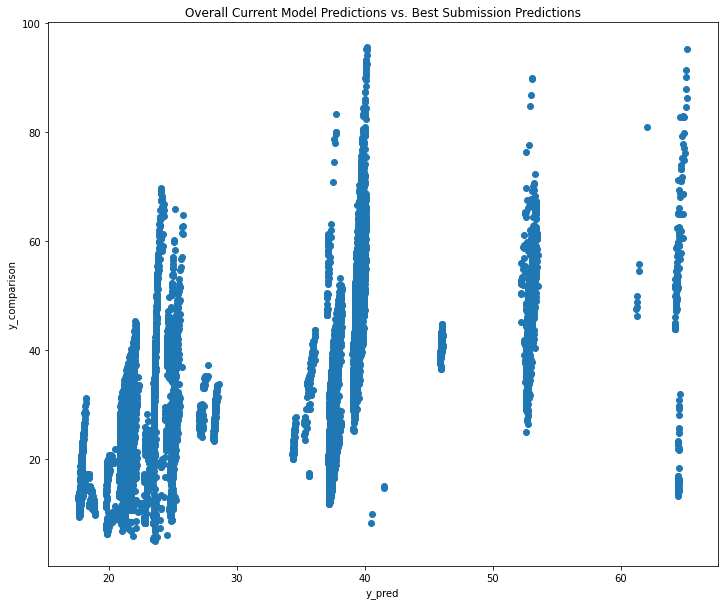

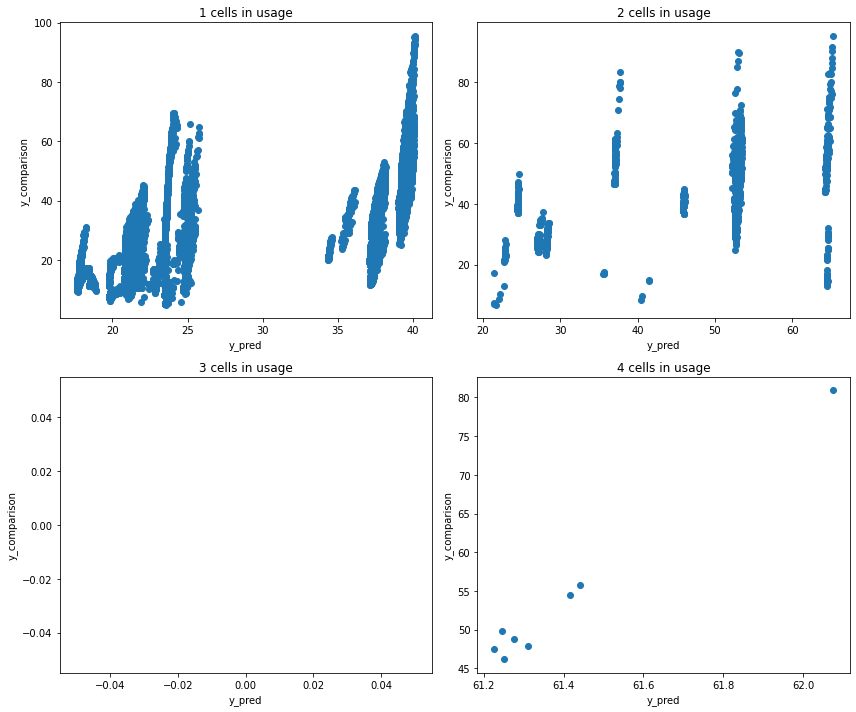

In [34]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 10)
best_submission = load_submission("bestsubmission.csv")
model_eval.compare_predictions_with(_predict_df_pca, best_submission['Energy'])